# Skip-gram Word2Vec



## Readings and References



* [Skip-gram tutorial](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) from Chris McCormick 
* [Word2Vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [Neural Information Processing Systems, paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for Word2Vec also from Mikolov et al.
* A lot of material was taken from [Udacity](http://udacity.com/) Deep Learning Course 
* [Taiga corpus](https://tatianashavrina.github.io/taiga_site/downloads) was used for training
---
## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of word classes to analyze; one for each word in a vocabulary. Trying to one-hot encode these words is massively inefficient because most values in a one-hot vector will be set to zero. So, the matrix multiplication that happens in between a one-hot input vector and a first, hidden layer will result in mostly zero-valued hidden outputs.

To solve this problem and greatly increase the efficiency of our networks, we use what are called **embeddings**. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.

---
## Word2Vec

The Word2Vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words.

There are two architectures for implementing Word2Vec:
>* CBOW (Continuous Bag-Of-Words) and 
* Skip-gram

<img src="Images/word2vec_architectures.jpg" width=60%>

We'll be using the **skip-gram architecture** with **negative sampling** because it performs better than CBOW and trains faster with negative sampling.

---
## Loading Data



In [80]:
import os

text = ''
for f in os.listdir('Data/news/KP/texts/'):
    txt = open('Data/news/KP/texts/' + f).read()
    text += txt 

print(text[:100])



В первые три дня 2017 года в Тверской области в пожарах погибли несколько человек. Сейчас, когда у


## Pre-processing

The `preprocess` function from `utils.py` file does does pre-processing of our data:
>* It converts any punctuation into tokens. For example, `<COMMA>`. 
* It removes all words that show up five or fewer times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. 
* It returns a list of words in the text.


In [82]:
import utils
import numpy as np

# getting list of words
words = utils.preprocess(text,big=True)
print(words[:30])

['в', 'один', 'три', 'день', '2017', 'год', 'в', 'тверская', 'область', 'в', 'пожар', 'погибнуть', 'несколько', 'человек', '<period>', 'сейчас', '<comma>', 'когда', 'ударить', 'аномальный', 'мороз', '<comma>', 'вероятность', 'возгорание', 'только', 'возрасти', '<period>', 'главный', 'мчс', 'россия']


In [577]:
import json

with open('words.txt', 'w') as f:
    json.dump(words, f)

In [83]:
# printing some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 7745131
Unique words: 29173


In [594]:
import utils
# creating two dictionaries to convert words to integers and back again
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
# storing all integer words in list
int_words = [vocab_to_int[word] for word in words]

print(int_words[:30])

[3, 38, 120, 75, 155, 20, 3, 843, 30, 3, 147, 199, 175, 43, 1, 135, 2, 190, 1022, 4082, 291, 2, 4138, 717, 131, 4700, 1, 275, 163, 55]


## Subsampling

Words that show up often don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.


In [87]:
from collections import Counter
import random
import numpy as np
from tqdm import tqdm_notebook

threshold = 1e-5
word_counts = Counter(int_words)

total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
# discarding some frequent words, according to the subsampling equation
# removing words with drop probability greater than 0.9
# creating a new list of words for training
train_words = [word for word in int_words if p_drop[word] < 0.9]


print(len(int_words))
print(len(p_drop))
print(len(train_words))

7745131
29173
3668394


## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to define a surrounding _context_ and grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $[ 1: C ]$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

So, we're creating function `get_target`.

In [89]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx+1:stop+1]
    
    return list(target_words)

### Generating Batches 

Here's a generator function that returns batches of input and target data for our model, using the `get_target` function from above. The idea is that it grabs `batch_size` words from a words list. Then for each of those batches, it gets the target words in a window.

In [91]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]

    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

---
## Validation

This function will help us observe our model as it learns. We're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them using the cosine similarity: 

$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$


We can encode the validation words as vectors $\vec{a}$ using the embedding table, then calculate the similarity with each word vector $\vec{b}$ in the embedding table. With the similarities, we can print out the validation words and words in our embedding table semantically similar to those words. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [93]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

---
# SkipGram model

An Embedding layer takes in a number of inputs, importantly:
* **num_embeddings** – the size of the dictionary of embeddings, or how many rows you'll want in the embedding weight matrix
* **embedding_dim** – the size of each embedding vector; the embedding dimension

Below is an approximate diagram of the general structure of our network.
<img src="Images/skip_gram_arch.jpg" width=60%>

>* The input words are passed in as batches of input word tokens. 
* This will go into a hidden layer of linear units (our embedding layer). 
* Then, finally into a softmax output layer. 

We'll use the softmax layer to make a prediction about the context words by sampling.

---
## Negative Sampling

For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct example, but only a small number of incorrect, or noise, examples.

There are two modifications we need to make. First, since we're not taking the softmax output over all the words, we're really only concerned with one output word at a time. Similar to how we use an embedding table to map the input word to the hidden layer, we can now use another embedding table to map the hidden layer to the output word. Now we have two embedding layers, one for input words and one for output words. Secondly, we use a modified loss function where we only care about the true example and a small subset of noise examples.

$$
- \large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)} -
\sum_i^N \mathbb{E}_{w_i \sim P_n(w)}\log{\sigma\left(-u_{w_i}\hspace{0.001em}^\top v_{w_I}\right)}
$$

First of all, $u_{w_O}\hspace{0.001em}^\top$ is the embedding vector for our "output" target word (transposed, that's the $^\top$ symbol) and $v_{w_I}$ is the embedding vector for the "input" word. Then the first term 

$$\large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)}$$

says we take the log-sigmoid of the inner product of the output word vector and the input word vector. Now the second term, let's first look at 

$$\large \sum_i^N \mathbb{E}_{w_i \sim P_n(w)}$$ 

This means we're going to take a sum over words $w_i$ drawn from a noise distribution $w_i \sim P_n(w)$. The noise distribution is basically our vocabulary of words that aren't in the context of our input word. In effect, we can randomly sample words from our vocabulary to get these words. $P_n(w)$ is an arbitrary probability distribution though, which means we get to decide how to weight the words that we're sampling. This could be a uniform distribution, where we sample all words with equal probability. Or it could be according to the frequency that each word shows up in our text corpus, the unigram distribution $U(w)$. The authors found the best distribution to be $U(w)^{3/4}$, empirically. 

Finally, in 

$$\large \log{\sigma\left(-u_{w_i}\hspace{0.001em}^\top v_{w_I}\right)},$$ 

we take the log-sigmoid of the negated inner product of a noise vector with the input vector. 


The sigmoid function returns a probability between 0 and 1. The first term in the loss pushes the probability that our network will predict the correct word $w_O$ towards 1. In the second term, since we are negating the sigmoid input, we're pushing the probabilities of the noise words towards 0.

### Training


In [94]:
import torch
from torch import nn
import torch.optim as optim

In [97]:
import Skipgram
import Negsamp

# Unfortunately only have cpu
device = 'cpu'

#device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Get our noise distribution
# Using word frequencies calculated earlier in the notebook
word_freqs = np.array(sorted(freqs.values(), reverse=True))
unigram_dist = word_freqs/word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))

# instantiating the model
embedding_dim = 300
model = Skipgram.SkipGramNeg(len(vocab_to_int), embedding_dim, noise_dist=noise_dist).to(device)

# using the loss that we defined
criterion = Negsamp.NegativeSamplingLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 1500
steps = 0
epochs = 5

# train for some number of epochs
for e in range(epochs):
    
    # get our input, target batches
    for input_words, target_words in get_batches(train_words, 512):
        steps += 1
        inputs, targets = torch.LongTensor(input_words), torch.LongTensor(target_words)
        inputs, targets = inputs.to(device), targets.to(device)
        
        # input, outpt, and noise vectors
        input_vectors = model.forward_input(inputs)
        output_vectors = model.forward_output(targets)
        noise_vectors = model.forward_noise(inputs.shape[0], 5)

        # negative sampling loss
        loss = criterion(input_vectors, output_vectors, noise_vectors)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss stats
        if steps % print_every == 0:
            print("Epoch: {}/{}".format(e+1, epochs))
            print("Loss: ", loss.item()) # avg batch loss at this point in training
            valid_examples, valid_similarities = cosine_similarity(model.in_embed, device=device)
            _, closest_idxs = valid_similarities.topk(6)

            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...\n")

Epoch: 1/5
Loss:  4.0503644943237305
который | кс, депортация, патрулировать, цирк-шапито, 720
о | автоматический, «2017, взламывать, давао, станок
и | аниме, бойко, фонтанка, недовольный, «локомотив-кубань»
январь | разврат, абрам, «кп-ульяновск», известный, телицин
улица | «правоохранительный, газовик, гречка, досадный, sberbank
рассказать | «заминировал», «ямал», йогурт, balkans, объём
они | сумерки, соперничество, влажность, ванино, островной
- | «ростов», «глава, проезжать, «ржд», результативность
килограмм | уход, переподготовка, составлять, ооо, повод
крыша | максимальный, знак, фронт, мимо, мочь
устанавливаться | сотрудник, наступление, «вконтакте», злоумышленник, самарский
приём | пациент, необходимый, показание, процент, оказывать
говориться | подать, шить, сей, оперативный, «твиттере»
привести | неисправность, 5, из-за, энергия, mp4
56 | угроза, 72-летний, вылет, предаваться, главное
игорь | забрать, смена, фольклорный, автомобилист, миссия
...

Epoch: 1/5
Loss:  3.192400693

Epoch: 3/5
Loss:  2.0694580078125
область | suzuki, -саратов, причинение, 74-летний, отключаться
декабрь | ик-9, карамзин, макеевка, 9а, «светлый
<left_paren> | президентура, 1936, «салават, жилмассив, недвижимость>новость
при | дача, «просто, «протон-м», еленовка, ангар
ещё | сход, столб, жеребец, земнухов, «лады»
– | осветительный, сковываться, струнный, объезд, выдвигаться
<comma> | справа, 133, выпадать, мочевой, бобби
а | совершить, направо, совершать, пятиэтажка, ноябрь
ооо | директор, компания, предприятие, муп, оао
занять | занимать, третье, выиграть, завоевать, победить
ранний | обычный, поздний, когда, известно, чуть
новгород | нижний, nnov, нижегородский, 26, 29
вчера | сегодня, вечером, понедельник, случиться, часы
особый | вид, внимание, режим, тёмно-русый, всегда
подтвердить | отметить, экспертиза, заявить, сми, иностранный
игорь | александр, сергей, вадим, владимир, глава
...

Epoch: 3/5
Loss:  1.9958668947219849
а | июль, направо, студентка, этаж, совершить
место | проп

Epoch: 4/5
Loss:  1.9072580337524414
область | 74-летний, suzuki, 146, отключаться, 387
а | переброситься, категория, этаж, именитый, слободзейский
от | мундиаля, думать, благоустраивать, нотариальный, сауна
также | комната, беспорядочный, рюмка, «университет», крик
но | интернет-сообщество, джейк, неэффективный, восьмимесячный, яд
тысяча | нормализация, атаковать, рх, сливен, оповещение
этот | посоревноваться, общенациональный, дублёнка, игнатенко, 350
сообщать | аналитический, наслаждаться, «ладу», 40-градусный, конкурентоспособность
kaliningrad | калининград, калининградский, spb, vrn, bryansk
местами | прояснение, ветер, ожидаться, небольшой, гололедица
тасс | передавать, риа, приводить, ранее, интерфакс
оружие | огнестрельный, патрон, пистолет, боеприпас, предмет
русский | язык, болгария, православный, народ, литература
билет | стоимость, проездной, цена, скидка, бесплатный
лететь | минобороны, сирия, ту-154, самолёт, сирию»
предоставить | предоставлять, документ, указать, подложн

## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture.

In [98]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [99]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.in_embed.weight.to('cpu').data.numpy()
# saving all our embeddings in file
np.savetxt('embeddings.txt',embeddings)

In [102]:
viz_words = 100
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

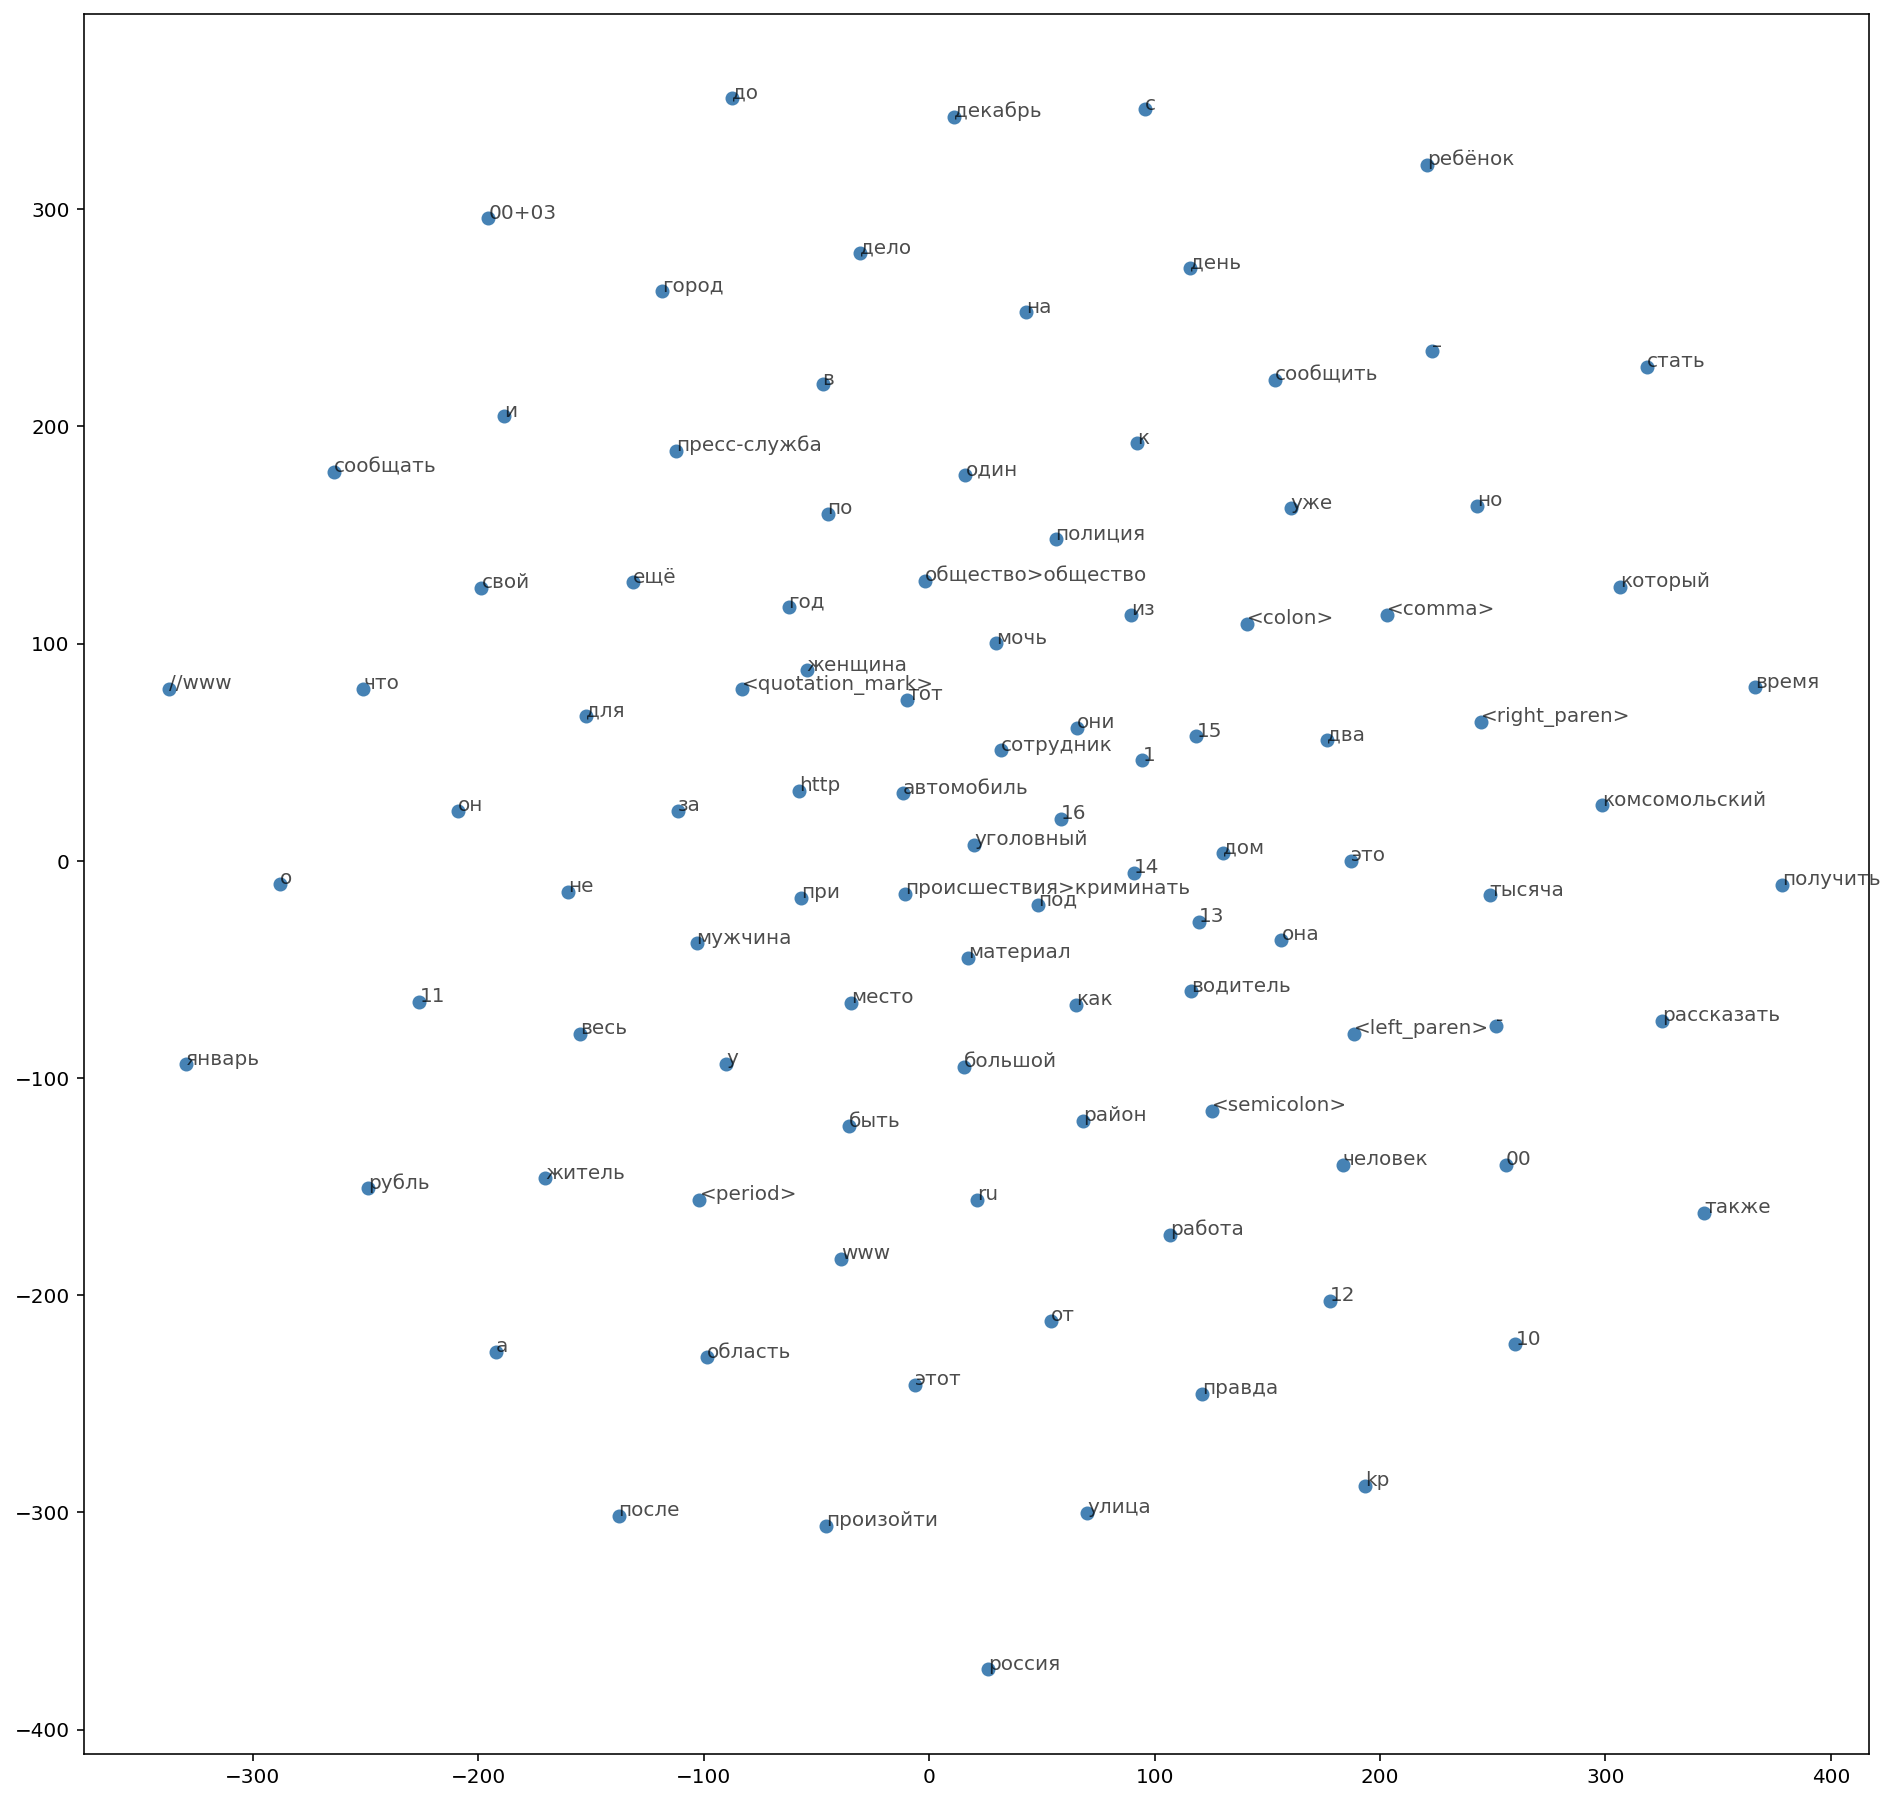

In [103]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

## Preprocessing of test data


In [407]:
import pandas as pd
import numpy as np
# reading our data 
data = pd.read_csv('Data/lenta-ru-news.csv')
# deleting nan values from data
data = data.dropna()
data = data.reset_index()
# we will need only texts and topics
data = data[['text','topic']]


data.head()

,index,text,topic
0,0,Вице-премьер по социальным вопросам Татьяна Го...,Россия
1,1,Австрийские правоохранительные органы не предс...,Спорт
2,2,Сотрудники социальной сети Instagram проанализ...,Путешествия
3,3,С начала расследования российского вмешательст...,Мир
4,4,Хакерская группировка Anonymous опубликовала н...,Мир


In [409]:
# making topic-label dictionary 
unique_topics = data['topic'].unique()

di = {unique_topics[i] : i for i in range(len(unique_topics))}

data = data.replace({'topic':di})

In [592]:
# Checking the quantity of texts for each topic in data
for i in range(len(unique_topics)):
    is_i = data['topic']==i
    topic_i = data[is_i]
    print("class №", i, "  ", topic_i.shape[0])

class № 0    160516
class № 1    64421
class № 2    6408
class № 3    136679
class № 4    53402
class № 5    44675
class № 6    19596
class № 7    79538
class № 8    53802
class № 9    21734
class № 10    53136
class № 11    27611
class № 12    7766
class № 13    7399
class № 14    1268
class № 15    340
class № 16    666
class № 17    0
class № 18    0
class № 19    0
class № 20    0
class № 21    0
class № 22    0


In [410]:
# deleting very small classes (classes 17-22 have much less texts than others)
for i in range(23):
    topic_i = data[data['topic']==i]
    if topic_i.shape[0] < 150:
        data = data[data.topic != i]
        
data = data.reset_index()

data = data[['text','topic']]

In [558]:
from sklearn.utils import shuffle
# shuffling our data 
shuffled_data = shuffle(data)

# We can't work with the whole dataset here
small_data = shuffled_data[:30000]

small_data = small_data.reset_index()

small_data = small_data[['text','topic']]

np_texts = small_data['text'].values
targets = small_data['topic'].values

17

In [563]:
import utils
from tqdm import tqdm_notebook
# tokenizing texts 
tokenized_texts = []

for text in tqdm_notebook(np_texts):
    tokenized = utils.preprocess(text, big=False)
    tokenized_texts.append(tokenized)
    

In [573]:
import json
# saving all our tokens in file
with open('test_tokens.txt', 'w') as f:
    json.dump(tokenized_texts, f)

In [565]:
def embedding_mean(text):
    ''' Counts mean embedding of text  '''
    
    return np.array([embeddings[vocab_to_int[word]] for word in text if word in set_words]).mean(axis=0)



In [566]:
# loading embeddings and tokens from our files
embeddings = np.loadtxt('embeddings.txt')

with open('words.txt') as f:
    words = json.load(f)

with open('test_tokens.txt') as f:
    test_tokens = json.load(f)

# count our mean embeddings    
set_words = set(words)
mean_embeddings = []

for bunch in tqdm_notebook(test_tokens):
    mean = embedding_mean(bunch)
    if np.isnan(mean).any():
        mean_embeddings.append(np.zeros((embedding_dim,)))
    else:
        mean_embeddings.append(mean)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
//anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Classification 

We will do our classification with SGD Classifier, using our mean embeddings as features and topic labels as classes.

In [601]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(mean_embeddings, targets, test_size = 0.2, random_state = 42, 
                                                    stratify = targets)

In [602]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier()
# train the classifier
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [603]:
from sklearn import metrics
# predict targets
y_train_pred = clf.predict(X_train)
print("Train Accuracy: {}".format(round(metrics.accuracy_score(y_train, y_train_pred),2)))

Train Accuracy: 0.74


In [604]:
y_pred = clf.predict(X_test)
print("Test Accuracy: {}".format(round(metrics.accuracy_score(y_test, y_pred),2)))

Test Accuracy: 0.72


In [609]:
# saving true test classes
np.savetxt('results/y_test.txt',y_test)
    
# saving our predictions
np.savetxt('results/y_pred.txt',y_pred)
    
